In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
test = pd.read_csv('C:/Users/user/github/Data/aifactory/test_data.csv')
train = pd.read_csv('C:/Users/user/github/Data/aifactory/train_data.csv')

In [3]:
test.drop('out_pressure',axis=1, inplace=True)
train.drop('out_pressure',axis=1, inplace=True)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [5]:
te = test.drop(['type'], axis=1)
tr = train.drop(['type'], axis= 1)

In [6]:
ss = StandardScaler()

In [7]:
ss.fit(tr)

StandardScaler()

In [8]:
train_sc = ss.transform(tr)

In [9]:
test_sc = ss.fit_transform(te)

In [10]:
epsilon = 0.3
min_samples = 10
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(train_sc)

In [11]:
dbscan_test = DBSCAN(eps=epsilon, min_samples=min_samples).fit(test_sc)

In [12]:
labels = dbscan.fit_predict(train_sc)

In [13]:
train_sc = pd.DataFrame(train_sc)

In [14]:
train_sc['label'] = labels

In [15]:
train_sc[train_sc['label'] != -1].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462],
           dtype='int64', length=2447)

In [16]:
train_sc = train_sc.loc[train_sc[train_sc['label'] != -1].index].drop('label', axis=1)

In [17]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV

In [18]:
model = OneClassSVM()

In [19]:
param_grid = {
    'kernel': ['rbf','poly','linear', 'sigmoid'],
    'nu': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'gamma' : [0.1, 1, 'scale', 'auto']
}

In [20]:
param_grid = {
    'kernel': ['rbf','poly','linear', 'sigmoid'],
    'nu': [0.01, 0.5, 0.1, 0.2, 0.3, 0.4],
    'gamma' : ['scale', 'auto']
}

In [21]:
grid_search = GridSearchCV(model, param_grid, scoring='f1_weighted', cv=5)

In [22]:
grid_search.fit(train_sc)

GridSearchCV(cv=10, estimator=OneClassSVM(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
                         'nu': [0.01, 0.5, 0.1, 0.2, 0.3, 0.4]},
             scoring='f1_weighted')

In [23]:
best_params = grid_search.best_params_
print(f'Best Parmas:{best_params}')

Best Parmas:{'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.01}


In [24]:
svm_fit = OneClassSVM(**best_params)
svm_fit.fit(train_sc)

OneClassSVM(nu=0.01)

In [25]:
prediction = svm_fit.predict(test_sc)

In [26]:
prediction

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [27]:
prediction = pd.DataFrame(prediction).replace(1,0).replace(-1,1)

In [28]:
prediction.columns = ['label']

In [29]:
score = svm_fit.score_samples(test_sc)

In [30]:
threshold = np.quantile(score,0.05)

In [31]:
index = np.where(score < threshold)

In [32]:
prediction['label'] = 0

In [33]:
prediction.loc[index[0], 'label'] = 1

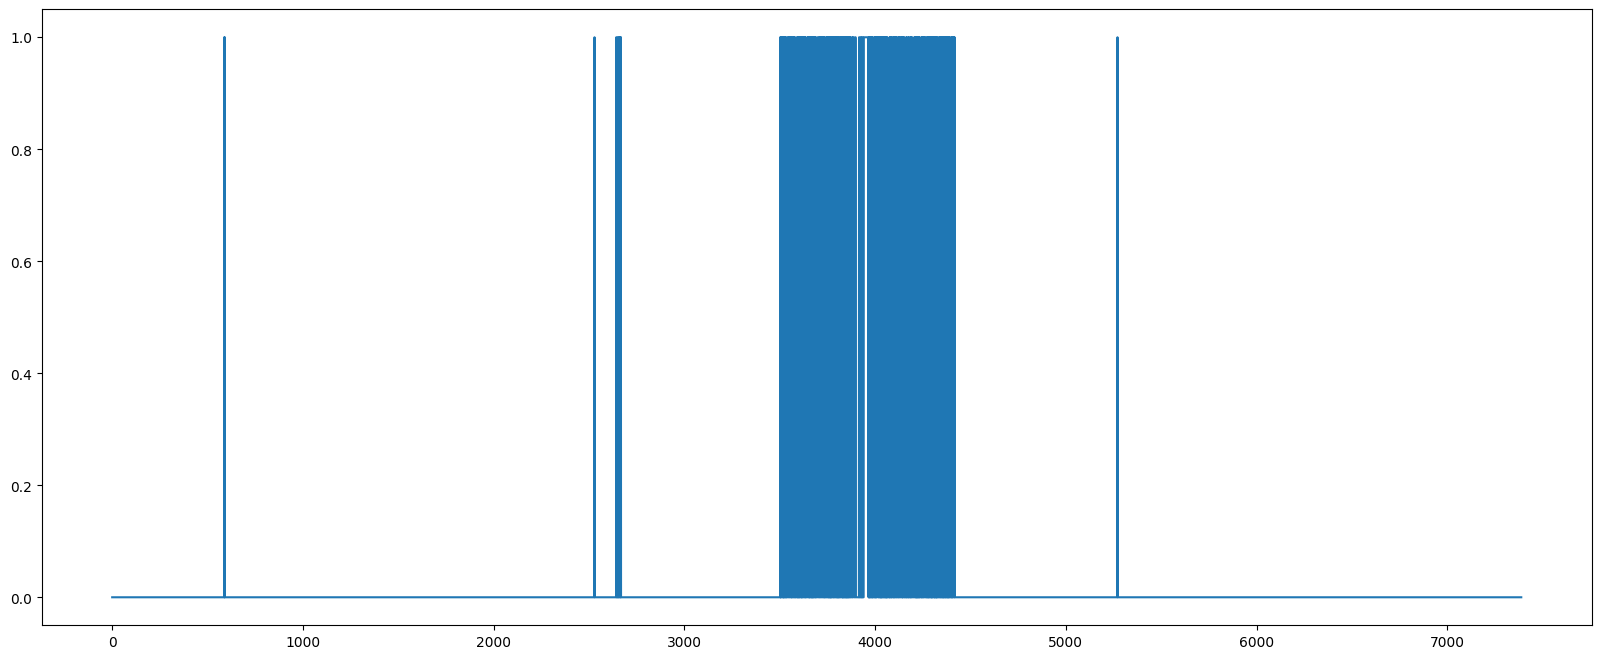

In [34]:
plt.figure(figsize= (20,8))
plt.plot(prediction)

In [35]:
prediction.label.value_counts()

0    7020
1     369
Name: label, dtype: int64

prediction.to_csv('C:/Users/User/Desktop/svdd.csv', index = False)